### Magics

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

%load_ext watermark
%watermark -a 'Salomon Tetelepa' -d -t -v -p keras,tensorflow,numpy,pandas,matplotlib -g

Using TensorFlow backend.


Salomon Tetelepa 2019-09-02 07:51:01 

CPython 3.6.7
IPython 7.2.0

keras 2.2.4
tensorflow 1.11.0
numpy 1.16.2
pandas 0.23.4
matplotlib 2.0.2
Git hash: 643ff5f33e461f685bbb59d39c034ebbf67e9036


### Imports

In [2]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd

import logging
import pickle
import cv2
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam

from sklearn.linear_model import LogisticRegression

### Settings

In [3]:
# path settings
try:
    # Running from a python file"
    project_path = Path(os.path.dirname(os.path.abspath(__file__)), os.pardir)
except NameError as e:
    # Running from console or notebook"
    project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"

In [5]:
# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import packages
from utils.identify import *
from utils.log import *
from set_cardgame.dataset import *

#logger = setup_logger(level=logging.INFO)

### Load dataset

In [6]:
# load training and validation data
X_train, y_train, X_val, y_val = load_dataset(nr_images=81, output_path=output_path)

Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.


In [7]:
# load meta data
df_meta, df_meta_dummies = load_metadata()

#### Debug

X_train.shape: (81, 96, 128, 3)
y_train.shape: (81,)
X_val.shape: (81, 96, 128, 3)
y_val.shape: (81,)


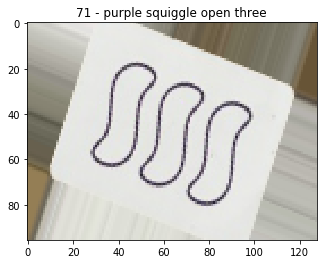

,filename,card_id,variant,color,shape,fill,number
0,0_red_round_solid_one.jpg,0,0,red,round,solid,one
1,1_red_round_solid_one.jpg,0,1,red,round,solid,one
2,2_red_round_solid_one.jpg,0,2,red,round,solid,one
3,3_red_round_solid_one.jpg,0,3,red,round,solid,one
4,0_red_round_solid_two.jpg,1,0,red,round,solid,two


In [8]:
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_val.shape:", X_val.shape)
print("y_val.shape:", y_val.shape)

img_id = 11
card_id = y_train[img_id]
features = " ".join(df_meta[df_meta.card_id==int(card_id)][['color', 'shape','fill','number']].values[0])

plt.imshow(X_train[img_id]/255)
plt.title(f"{card_id} - {features}")
plt.show()

df_meta.head()

### One hot encoding

In [11]:
# Y_train_onehot = df_meta_dummies.iloc[list(y_train)].values
# Y_val_onehot = df_meta_dummies.iloc[list(y_val)].values

In [12]:
# print("df_meta_dummies.columns:", list(df_meta_dummies.columns))
# print("Y_train_onehot.shape:", Y_train_onehot.shape)
# print("Y_val_onehot.shape:", Y_val_onehot.shape)

### Preprocessing

Use a DNN model to generate image embeddings

In [13]:
# # initialize model
# resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(96, 128, 3))

# # layer name to extract
# layer_name = "res4a_branch1"

# # use model generate features for a specific layer
# intermediate_model = Model(inputs=resnet50.input, outputs=resnet50.get_layer(layer_name).output)
# intermediate_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[categorical_accuracy])

# X_train = preprocess_input_resnet50(X_train)
# X_val = preprocess_input_resnet50(X_val)

# # generate image embeddings
# X_train_embeddings = intermediate_model.predict(X_train)
# X_val_embeddings = intermediate_model.predict(X_val)

# # nr samples
# m_train = X_train_embeddings.shape[0]
# m_val = X_val_embeddings.shape[0]

# # reshape embeddings to 2D
# X_train_embeddings = X_train_embeddings.reshape(m_train, -1)
# X_val_embeddings = X_val_embeddings.reshape(m_val, -1)

In [14]:
# print("X_train.shape:", X_train.shape)
# print("X_train_embeddings.shape:", X_train_embeddings.shape)
# print("X_val.shape:", X_val.shape)
# print("X_val_embeddings.shape:", X_val_embeddings.shape)

### Setup model

In [15]:
# # fit model
# clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train_embeddings, y_train)

# # evaluate model on validation set
# val_score = clf.score(X_val_embeddings, y_val)

# print(f"validation score: {val_score}")

### Find best performing layer

In [16]:
X_train = preprocess_input_resnet50(X_train)
X_val = preprocess_input_resnet50(X_val)

print("X_train.shape:", X_train.shape)
print("X_val.shape:", X_val.shape)

X_train.shape: (81, 96, 128, 3)
X_val.shape: (81, 96, 128, 3)


In [4]:
### Imports
import os
import sys
import numpy as np
import pandas as pd
import click
import logging
import pickle
import cv2
import gc
from pathlib import Path
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# path settings
#project_path = Path(os.path.dirname(os.path.abspath(__file__)), os.pardir)
project_path = Path(os.getcwd(), os.pardir)
output_path = project_path / "output"

# add project root to pythonpath
sys.path.insert(0, str(project_path / "src"))

# import custom packages
from utils.identify import *    
from utils.log import *
from set_cardgame.dataset import *

# setup logging
logger = setup_logger(level=logging.INFO)


#@click.command()
#@click.option('--normalize', default=None, help='how to normalize data, possible values: {"standard", "minimax"}.')
#@click.option('--nr_images', default=81, help='Number of images to generate for training')
def train(normalize, nr_images):
    logger.info(f"parameter: normalize: {normalize}")
    logger.info(f"parameter: nr_images: {nr_images}")

    # load training and validation data
    X_train, y_train, X_val, y_val = load_dataset(nr_images=nr_images, output_path=output_path)

    logger.debug("X_train.shape:", X_train.shape)
    logger.debug("X_val.shape:", X_val.shape)

    # load meta data
    df_meta, df_meta_dummies = load_metadata()

    # initialize intermediate model
    resnet50 = ResNet50(include_top=False, weights='imagenet', pooling=None, input_shape=(96, 128, 3))

    # resnet preprocessing
    X_train = preprocess_input_resnet50(X_train)
    X_val = preprocess_input_resnet50(X_val)

    # nr samples
    m_train = X_train.shape[0]
    m_val = X_val.shape[0]

    # dictionary to store results
    results = {
        'layer_id': [],
        'layer_name': [], 
        'nr_images': [], 
        'normalize': [],
        'train_score': [], 
        'val_score': []
    }

    # loop randomly through layers
    nr_layers = len(resnet50.layers)
    random_index = np.random.choice(nr_layers, size=nr_layers, replace=False)
    for i, layer_id in enumerate(random_index):    
        
        # csv file for storing results for this layer
        layer_output_csv = output_path / f'results{layer_id}.csv'
        
        # check if there is a result for this layer (allows for subsequent execution) 
        if layer_output_csv.is_file():
            logger.warning(f"skipping layer: {layer_id}, found previous results for this layer")
            continue
        
        layer_name = resnet50.layers[layer_id].name
        logger.info(f"{i} - {layer_name}")

        # compile model, use specific layer as output
        intermediate_model = Model(inputs=resnet50.input, outputs=resnet50.get_layer(layer_name).output)
        intermediate_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[categorical_accuracy])

        # generate image embeddings
        X_train_embeddings = intermediate_model.predict(X_train)
        X_val_embeddings = intermediate_model.predict(X_val)

        # reshape embeddings to 2D
        X_train_embeddings = X_train_embeddings.reshape(m_train, -1)
        X_val_embeddings = X_val_embeddings.reshape(m_val, -1)
        
        if normalize == "standard":
            logger.info("normalize using standard scaling")
            scaler = StandardScaler()
        elif normalize == "minmax":
            logger.info("normalize using standard scaling")
            scaler = MinMaxScaler()
        else:
            logger.info("no normalization")
            scaler = None

        if scaler:
            logger.info("noramlize data")
            X_train_embeddings = scaler.fit_transform(X_train_embeddings)
            X_val_embeddings = scaler.transform(X_val_embeddings)

        # fit model
        clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train_embeddings, y_train)

        train_score = clf.score(X_train_embeddings, y_train)
        val_score = clf.score(X_val_embeddings, y_val)
        logger.info(f"score for layer {layer_id} - layer_name {layer_name}, train_score: {train_score:.2f}, val_score: {val_score:.2f}")
        
        # store results
        results['layer_id'].append(layer_id)
        results['layer_name'].append(layer_name)
        results['nr_images'].append(nr_images)
        results['normalize'].append(normalize)
        results['train_score'].append(train_score)
        results['val_score'].append(val_score)
        
        # export results to csv
        results_df = pd.DataFrame(data=results)
        results_df.to_csv(layer_output_csv)

        # garbage collection
        gc.collect()

In [5]:
train(normalize="standard", nr_images=81)

2019-08-18 13:02:04,973 - INFO - :<ipython-input-4-870f39843195> - parameter: normalize: standard
2019-08-18 13:02:04,974 - INFO - :<ipython-input-4-870f39843195> - parameter: nr_images: 81


Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.


/Users/salomon/miniconda3/envs/set-detection/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
2019-08-18 13:02:14,419 - WARNING - :<ipython-input-4-870f39843195> - skipping layer: 143, found previous results for this layer
2019-08-18 13:02:14,420 - WARNING - :<ipython-input-4-870f39843195> - skipping layer: 163, found previous results for this layer
2019-08-18 13:02:14,421 - WARNING - :<ipython-input-4-870f39843195> - skipping layer: 142, found previous results for this layer
2019-08-18 13:02:14,422 - INFO - :<ipython-input-4-870f39843195> - 3 - bn3c_branch2c
2019-08-18 13:02:19,055 - INFO - :<ipython-input-4-870f39843195> - normalize using standard scaling
2019-08-18 13:02:19,057 - INFO - :<ipython-input-4-870f39843195> - noramlize data
2019-08-18 13:03:06,770 - INFO - :<ipython-input-4-870f39843195> - sc

2019-08-18 13:09:06,644 - INFO - :<ipython-input-4-870f39843195> - noramlize data
/Users/salomon/miniconda3/envs/set-detection/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2019-08-18 13:09:14,702 - INFO - :<ipython-input-4-870f39843195> - score for layer 114 - layer_name bn4d_branch2a, train_score: 1.00, val_score: 0.12
2019-08-18 13:09:14,909 - INFO - :<ipython-input-4-870f39843195> - 20 - res5c_branch2b
2019-08-18 13:09:26,828 - INFO - :<ipython-input-4-870f39843195> - normalize using standard scaling
2019-08-18 13:09:26,829 - INFO - :<ipython-input-4-870f39843195> - noramlize data
/Users/salomon/miniconda3/envs/set-detection/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
2019-08-18 13:09:31,507 - INFO - :<

2019-08-18 13:14:51,735 - INFO - :<ipython-input-4-870f39843195> - noramlize data
2019-08-18 13:16:13,889 - INFO - :<ipython-input-4-870f39843195> - score for layer 2 - layer_name conv1, train_score: 1.00, val_score: 0.05
2019-08-18 13:16:14,028 - INFO - :<ipython-input-4-870f39843195> - 38 - activation_6
2019-08-18 13:16:19,701 - INFO - :<ipython-input-4-870f39843195> - normalize using standard scaling
2019-08-18 13:16:19,716 - INFO - :<ipython-input-4-870f39843195> - noramlize data
2019-08-18 13:16:53,624 - INFO - :<ipython-input-4-870f39843195> - score for layer 28 - layer_name activation_6, train_score: 1.00, val_score: 0.06
2019-08-18 13:16:53,758 - INFO - :<ipython-input-4-870f39843195> - 39 - bn4a_branch1
2019-08-18 13:17:00,991 - INFO - :<ipython-input-4-870f39843195> - normalize using standard scaling
2019-08-18 13:17:00,992 - INFO - :<ipython-input-4-870f39843195> - noramlize data
2019-08-18 13:17:23,980 - INFO - :<ipython-input-4-870f39843195> - score for layer 90 - layer_na

KeyboardInterrupt: 

In [28]:
X_train, y_train, X_val, y_val = load_dataset(nr_images=8, output_path=output_path)

Found 243 images belonging to 81 classes.
Found 81 images belonging to 81 classes.


In [29]:
X_train.mean()

198.96605

In [30]:
X_train = preprocess_input_resnet50(X_train)

In [32]:
X_train.mean()

84.16673

In [43]:
df = pd.read_csv(output_path / 'results.csv')

FileNotFoundError: [Errno 2] File b'/Users/salomon/work/fink-projects/set-detection/notebooks/../output/results.csv' does not exist: b'/Users/salomon/work/fink-projects/set-detection/notebooks/../output/results.csv'

In [33]:
from sklearn.preprocessing import MinMaxScaler
    data = [[-1, 2], [-0.5, 6], [0, 10], [1, 18]]
    scaler = MinMaxScaler()
    print(scaler.fit(data))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [36]:
X_train.reshape(X_train.shape[0], -1).mean()

84.16673

In [40]:
X_train_norm = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1))

In [42]:
X_train_norm.mean()

0.6894875

In [20]:
# loop randomly through layers
nr_layers = len(resnet50.layers)
random_index = np.random.choice(nr_layers, size=nr_layers, replace=False)
for i, layer_id in enumerate(random_index):
    # csv file for storing results for this layer
    layer_output_csv = output_path / f'results{layer_id}.csv'
    
    # check if there is a result for this layer (allows for subsequent execution) 
    if layer_output_csv.is_file():
        logger.warning(f"skipping layer: {layer_id}, found previous results for this layer")
        continue
    
    layer_name = resnet50.layers[layer_id].name
    logger.info(f"{i} - {layer_name}")

    # compile model, use specific layer as output
    intermediate_model = Model(inputs=resnet50.input, outputs=resnet50.get_layer(layer_name).output)
    intermediate_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[categorical_accuracy])

    # generate image embeddings
    X_train_embeddings = intermediate_model.predict(X_train)
    X_val_embeddings = intermediate_model.predict(X_val)

    # reshape embeddings to 2D
    X_train_embeddings = X_train_embeddings.reshape(m_train, -1)
    X_val_embeddings = X_val_embeddings.reshape(m_val, -1)
     
        
    # fit model
    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train_embeddings, y_train)

    val_score = clf.score(X_val_embeddings, y_val)
    logger.info(f"validation score for layer {layer_id} - layer_name {layer_name}: val_score: {val_score}")
    
    results['layer_id'].append(layer_id)
    results['layer_name'].append(layer_name)
    results['val_score'].append(val_score)
    
    # export results to csv
    results_df = pd.DataFrame(data=results)
    results_df.to_csv(layer_output_csv)

2019-08-17 11:33:41,323 - INFO - :<ipython-input-20-1d3185c50a52> - 0 - activation_121
2019-08-17 11:33:50,846 - INFO - :<ipython-input-20-1d3185c50a52> - validation score for layer 86 - layer_name activation_121: val_score: 0.024691358024691357
2019-08-17 11:33:50,861 - INFO - :<ipython-input-20-1d3185c50a52> - 1 - res3c_branch2c
2019-08-17 11:34:06,580 - INFO - :<ipython-input-20-1d3185c50a52> - validation score for layer 67 - layer_name res3c_branch2c: val_score: 0.06172839506172839
2019-08-17 11:34:06,585 - INFO - :<ipython-input-20-1d3185c50a52> - 2 - add_45


KeyboardInterrupt: 

In [ ]:
X_train_embeddings.mean()

In [18]:
resNet = ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3)) 

In [19]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(96, 128, 3))
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(96, 128, 3))

In [ ]:
# # initialize model
# resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(96, 128, 3))

# # layer name to extract
# layer_name = "res4a_branch1"

# # use model generate features for a specific layer
# intermediate_model = Model(inputs=resnet50.input, outputs=resnet50.get_layer(layer_name).output)
# intermediate_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=[categorical_accuracy])

### Evaluate

In [ ]:
# test_images = []
# for filename in os.listdir(str(project_path / "test_images")):
#     test_img = cv2.imread(str(project_path / "test_images" / filename))
#     test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
#     test_images.append(test_img)
# X_test = np.array(test_images)

# m_test = X_test.shape[0]

# X_test_embedded = intermediate_model.predict(X_test)
# X_test_embedded = X_test_embedded.reshape(m_test, -1)
# X_test_embedded.shape

# predictions_test = clf.predict(X_test_embedded)

In [ ]:
# for i, card_id in enumerate(predictions_test):
#     features = " ".join(df_meta[df_meta.card_id==int(card_id)][['color', 'shape','fill','number']].values[0])
#     plt.figure(figsize=(10, 5))
#     plt.title(f"{card_id} - {features}")
#     plt.imshow(X_test[i,:])
    
#     plt.show()

In [ ]:
# tmp

In [41]:
# columns for results csv. This list is used to create the results dataframe
result_columns = ['run_id', 'layer_id', 'layer_name', 'nr_images', 'normalize', 'train_score', 'val_score']

In [42]:
# path to output file with results    
results_csv_path = output_path / 'results.csv'

In [43]:
def get_or_create_results_file(results_csv_path, columns):
    try:
        df_results = pd.read_csv(results_csv_path)
    except FileNotFoundError:
        # create new results dataframe dictionary to store results
        df_results = pd.DataFrame(columns=columns)
    return df_results


In [44]:
df_results = get_or_create_results_file(results_csv_path, result_columns)

In [45]:
df_results

,run_id,layer_id,layer_name,nr_images,normalize,train_score,val_score


In [46]:
row = {}
row['run_id'] = "run_id"
row['layer_id'] = 1
row['layer_name'] = "test"
row['nr_images'] = 8
row['normalize'] = "normalize"
row['train_score'] = "train_score"
row['val_score'] = "val_score"

In [47]:
df_row = pd.DataFrame(data=[row])

In [48]:
pd.df_row

,layer_id,layer_name,normalize,nr_images,run_id,train_score,val_score
0,1,test,normalize,8,run_id,train_score,val_score


In [51]:
df_results = pd.concat([df_results, df_row], ignore_index=True)

/Users/salomon/miniconda3/envs/experiments/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [54]:
row = {}
row['run_id'] = "run_id"
row['layer_id'] = 2
row['layer_name'] = "test"
row['nr_images'] = 8
row['normalize'] = "normalize"
row['train_score'] = "train_score"
row['val_score'] = "val_score"
df_results = pd.concat([df_results, df_row], ignore_index=True)

In [55]:
df_results

,layer_id,layer_name,normalize,nr_images,run_id,train_score,val_score
0,1,test,normalize,8,run_id,train_score,val_score
1,1,test,normalize,8,run_id,train_score,val_score
2,1,test,normalize,8,run_id,train_score,val_score
